# Part 3. Building a model

In [1]:
from ipynb.fs.defs.part2_data_prep import load_dataset

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf 

Load datasets for training and validation

In [3]:
x_train, y_train = load_dataset("./data/chest_xray/train/", 6000)
x_test, y_test = load_dataset("./data/chest_xray/test/", 6000)

Finished reading the dataset
Finished reading the dataset


(5216, 150, 150, 3)


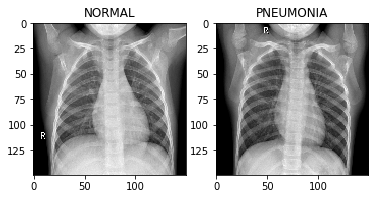

In [4]:
print(x_train.shape)

plt.subplot(1,2,1).set_title('NORMAL')
plt.imshow(x_train[np.argmax(y_train == 0)])

plt.subplot(1,2,2).set_title('PNEUMONIA')
plt.imshow(x_train[np.argmax(y_train == 1)])

In [41]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16

K.clear_session()

NUM_CLASSES = 2

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

![](https://www.jeremyjordan.me/content/images/2018/04/vgg16.png)

In [42]:
def print_layers(model):
    for idx, layer in enumerate(model.layers):
        print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

In [44]:
# Train only the bottom layers 
for layer in base_model.layers:
    layer.trainable = False
    
print_layers(model)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_pool, trainable: False
layer 11: block4_conv1, trainable: False
layer 12: block4_conv2, trainable: False
layer 13: block4_conv3, trainable: False
layer 14: block4_pool, trainable: False
layer 15: block5_conv1, trainable: False
layer 16: block5_conv2, trainable: False
layer 17: block5_conv3, trainable: False
layer 18: block5_pool, trainable: False
layer 19: flatten_1, trainable: True
layer 20: dense_1, trainable: True


In [45]:
optimizer_sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',     
              optimizer=optimizer_sgd, 
              metrics=['accuracy'])

In [9]:
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

# This callback saves the best versions of the model after each epoch
checkpoint = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    verbose=1
)

# Stop training when Loss on validation dataset has stopped improving.
early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=0, 
    verbose=1, 
    mode='auto', 
    baseline=None, 
    restore_best_weights=False
)

# This callback writes logs for TensorBoard
tensorboard = TensorBoard(
    log_dir='./Graph', 
    histogram_freq=0,  
    write_graph=True
)

lr_reduce = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    min_lr=1e-4,
    patience=4, 
    verbose=1
)

In [24]:
from sklearn.utils import class_weight
y_labels = np.argmax(y_train, axis=1)
classweight = class_weight.compute_class_weight('balanced', np.unique(y_labels), y_labels)
print(classweight)

[1.9448173  0.67303226]


In [25]:
history = model.fit(
    x=x_train, y=y_train,
    validation_split=0.1,
    callbacks=[checkpoint, early_stop, lr_reduce, tensorboard],
    shuffle=True,
    batch_size=64,
    epochs=10,
    verbose=1
)

Train on 4694 samples, validate on 522 samples
Epoch 1/10
4694/4694 [==============================] - 5s 1ms/step - loss: 11.5134 - acc: 0.2857 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00001: val_loss did not improve from 16.11810
Epoch 2/10
4694/4694 [==============================] - 5s 1ms/step - loss: 11.5134 - acc: 0.2857 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve from 16.11810
Epoch 00002: early stopping


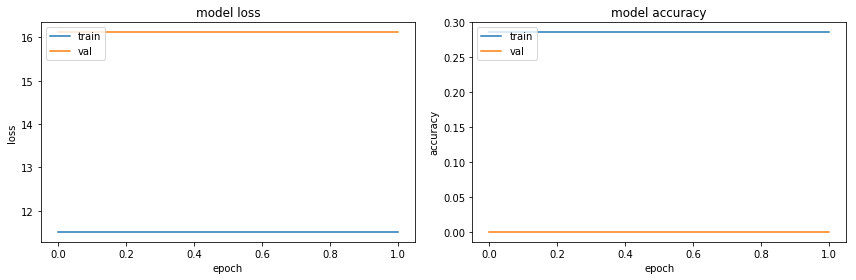

In [38]:
def plot_learning_curves(history):
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.tight_layout()
    
plot_learning_curves(history)

In [17]:
# Plot learning curves 


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [ ]:

history

In [12]:
# restore the best model
model.load_weights("best_model.h5")

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

Model Loss: 10.073809642058158, Accuracy: 0.375


In [14]:
# - restore best model
# - early stop
# - plot hitory curves

In [15]:
# plot_keras_learning_curve()



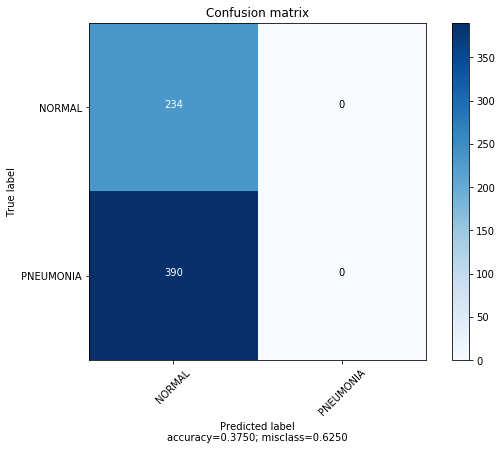

In [16]:
from sklearn.metrics import confusion_matrix
from model_morpho import *

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

conf_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(conf_mtx, target_names = ['NORMAL', 'PNEUMONIA'], normalize=False)